In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import re
from itertools import product

plt.rcParams.update({
    'font.size': 16,          # Base font size
})
bohr_to_angstrom = 0.52917721067

# Path to your repo (adjust this)
repo_path = "/home/x_pamca/postdoc_proj/EMTO_input_automation"

# Add it to sys.path if not already there
if repo_path not in sys.path:
    sys.path.append(repo_path)

#from modules.create_files import create_kstr_input, create_shape_input, create_kgrn_input, create_kfcd_input, create_job_ca, create_job_volume, create_eos_input

from modules.workflows import create_emto_inputs
from modules.eos import compute_equation_of_state, parse_energies
from modules.extract_results import parse_emto_output, save_report, generate_report
from modules.dos import DOSParser, DOSPlotter
from modules.eos_fortran_implementation import compute_equation_of_state as fortran
from modules.inputs import create_eos_input, parse_eos_output, morse_energy
import pandas as pd
import subprocess


# FePt - DLM

##### __Experimental lattice parameters__
```text
a = b = 3.86 Å
c = 3.76 Å
```
##### __Lattice vectors__
```text
1.00000000	0.00000000	0.00000000
0.00000000	1.00000000	0.00000000
0.00000000	0.00000000	0.97409326
```

##### __Atomic positions__
```text
        0.00000000      0.50000000      0.48704663
        0.50000000      0.00000000      0.48704663
        0.00000000      0.00000000      0.00000000
        0.50000000      0.50000000      0.00000000
```

In [2]:
percs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

fm_results_dict = {'a': 3.9432798563886626, 'c': 3.760908981340115, 'c/a': 0.9537514755, 'sws': 2.8665004099, 'vol': 58.48008882238663}
afm_results_dict = {'a': 4.020232300253283, 'a_%': 0.0, 'c': 3.6189259110150176, 'c_%': 0.0, 'c/a': 0.9001783083, 'c/a_%': 0.0, 'sws': 2.8666631477, 'sws_%': 0.0, 'vol': 58.49004953399884, 'vol_%': 0.0}

afm_results_dict['a_%'] = ((afm_results_dict['a'] - fm_results_dict['a']) / fm_results_dict['a']) * 100
afm_results_dict['c_%'] = ((afm_results_dict['c'] - fm_results_dict['c']) / fm_results_dict['c']) * 100
afm_results_dict['c/a_%'] = ((afm_results_dict['c/a'] - fm_results_dict['c/a']) / fm_results_dict['c/a']) * 100
afm_results_dict['sws_%'] = ((afm_results_dict['sws'] - fm_results_dict['sws']) / fm_results_dict['sws']) * 100 
afm_results_dict['vol_%'] = ((afm_results_dict['vol'] - fm_results_dict['vol']) / fm_results_dict['vol']) * 100


all_results_dict = {}

for p in percs: all_results_dict[p] = {'a': 0.0, 'a_%': 0.0, 'c': 0.0, 'c_%': 0.0, 'c/a': 0.0, 'c/a_%': 0.0, 'sws': 0.0, 'sws_%': 0.0, 'vol': 0.0, 'vol_%': 0.0}


In [3]:
afm_results_dict

{'a': 4.020232300253283,
 'a_%': 1.9514831984330607,
 'c': 3.6189259110150176,
 'c_%': -3.7752328234889916,
 'c/a': 0.9001783083,
 'c/a_%': -5.617099273363058,
 'sws': 2.8666631477,
 'sws_%': 0.0056772292596978325,
 'vol': 58.49004953399884,
 'vol_%': 0.017032654725385357}

# c/a

In [4]:

initial_ratio = 3.76 / 3.86
ratios = np.linspace(0.95 - 3*0.02, 0.95 + 3*0.02, 7)
initial_sws = [2.82]
k = 21

# for p in percs:
#     create_emto_inputs(
#         output_path="perc_"+str(format(p,'.1f'))+"/ratio_ca",
#         id_name="fept",
#         job_name=f"dlm_p{p}",
#         dmax=1.52,
#         lat=5,
#         ca_ratios=ratios,
#         sws_values=initial_sws,
#         ks = [k],
#         magn_type='pm',
#         perc = p,
#         from_cif=False,
#         job_mode='serial',
#         prcs=8,
#         time="05:00:00",
#         NL=3,
#         NQ3=4,
#         B=1.0,
#         fractional_coords=np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]))

In [5]:
ratios

array([0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01])

In [6]:

import subprocess

for p in percs:

    print(f"Processing percentage: {p} %")

    e_lda, e_gga = parse_energies(ratios, initial_sws, "perc_"+str(format(p,'.1f'))+"/ratio_ca", k, id_name="fept")

    create_eos_input("perc_"+str(format(p,'.1f'))+"/ratio_ca/eos.dat", 'eos_'+str(format(p,'.1f')), 'ratio c/a p '+str(format(p,'.1f')),  ratios, e_gga, fit_type='MO88')


    # Run command in specific directory, automatically returns to original
    result = subprocess.run('/home/x_pamca/postdoc_proj/emto/bin/eos.exe < eos.dat', 
                        shell=True, 
                        cwd="perc_"+str(format(p,'.1f'))+"/ratio_ca",
                        capture_output=True, 
                        text=True)



    print(result.stdout)

    results = parse_eos_output("perc_"+str(format(p,'.1f'))+"/ratio_ca/eos_" + str(format(p,'.1f')) +".out")

    all_results_dict[p]['c/a'] = results['morse'].rwseq
    all_results_dict[p]['c/a_%'] = (results['morse'].rwseq - fm_results_dict['c/a']) / fm_results_dict['c/a'] * 100

    print(f"  Opt c/a = {results['morse'].rwseq:.12f}\n")



Processing percentage: 0.0 %
EOS input file 'perc_0.0/ratio_ca/eos.dat' created successfully.
  Output file eos_0.0.out

  Opt c/a = 0.953751475500

Processing percentage: 0.1 %
EOS input file 'perc_0.1/ratio_ca/eos.dat' created successfully.
  Output file eos_0.1.out

  Opt c/a = 0.949776432300

Processing percentage: 0.2 %
EOS input file 'perc_0.2/ratio_ca/eos.dat' created successfully.
  Output file eos_0.2.out

  Opt c/a = 0.946626585100

Processing percentage: 0.3 %
EOS input file 'perc_0.3/ratio_ca/eos.dat' created successfully.
  Output file eos_0.3.out

  Opt c/a = 0.944937543000

Processing percentage: 0.4 %
EOS input file 'perc_0.4/ratio_ca/eos.dat' created successfully.
  Output file eos_0.4.out

  Opt c/a = 0.943935692700

Processing percentage: 0.5 %
EOS input file 'perc_0.5/ratio_ca/eos.dat' created successfully.
  Output file eos_0.5.out

  Opt c/a = 0.943158707500



In [7]:

# for p in percs:

#     # Parse file
#     morse = parse_eos_output("perc_"+str(format(p,'.1f'))+"/ratio_ca/eos_" + str(format(p,'.1f')) +".out")['morse']

#     # Get Morse parameters
#     a = morse.additional_params['a']
#     b = morse.additional_params['b']
#     c = morse.additional_params['c']
#     lambda_param = morse.additional_params['lambda']



#     # Get data points
#     r_data =  [p.r for p in morse.data_points]
#     efit_data = [p.efit for p in morse.data_points]

#     # Calculate relative energies at data points
#     e_relative_data = [morse_energy(r, a, b, c, lambda_param) for r in r_data]

#     # Find offset: E_absolute = E_relative + offset
#     # Use the first data point as reference
#     offset = efit_data[0] - e_relative_data[0]


#     # Create smooth curve
#     r_min = min(r_data)
#     r_max = max(r_data)
#     r_smooth = np.linspace(r_min * 0.95, r_max * 1.05, 200)
#     e_morse_smooth = np.array([morse_energy(r, a, b, c, lambda_param) + offset for r in r_smooth])

#     # Get DFT data
#     etot_data = [p.etot for p in morse.data_points]

#     # Plot
#     fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

#     # Top panel: Energy curve
#     ax1.plot(r_data, etot_data, 'ko', markersize=10, label='DFT Data', zorder=5)
#     ax1.plot(r_smooth, e_morse_smooth, 'b-', linewidth=2,
#                 label='Morse Equation', zorder=3, alpha=0.8)
#     ax1.axvline(morse.rwseq, color='gray', linestyle='--', alpha=0.5,
#                 label=f'R_eq = {morse.rwseq:.3f} au')

#     ax1.set_xlabel('c/a', fontsize=12)
#     ax1.set_ylabel('Total Energy (Ry)', fontsize=12)
#     ax1.set_title('Modified Morse EOS: Percentage ' + str(format(p,'.1f')) + ' %',
#                     fontsize=13, fontweight='bold')
#     ax1.legend(fontsize=10, loc='best')
#     ax1.grid(True, alpha=0.3)


#     plt.tight_layout()
#     plt.show()


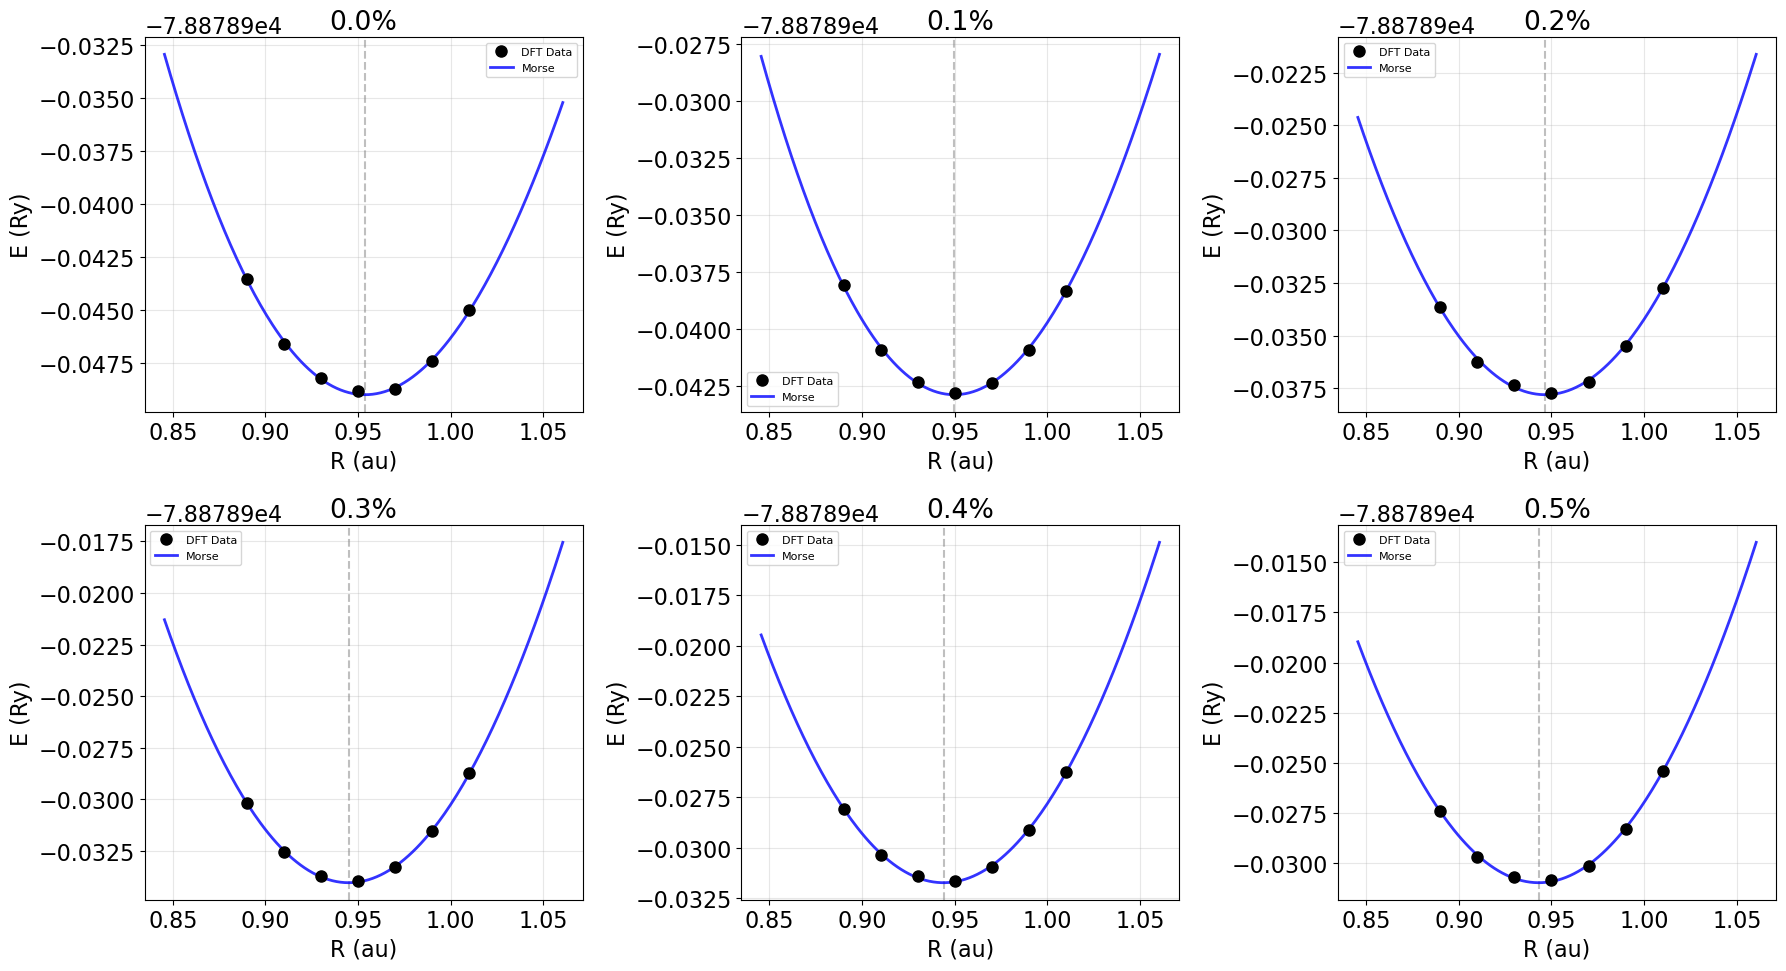

In [8]:
# Calculate subplot layout
n_percs = len(percs)
n_cols = 3  # adjust as needed
n_rows = (n_percs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_percs > 1 else [axes]

for i, p in enumerate(percs):
    # Parse file
    morse = parse_eos_output("perc_"+str(format(p,'.1f'))+"/ratio_ca/eos_" + str(format(p,'.1f')) +".out")['morse']

    # Get Morse parameters
    a = morse.additional_params['a']
    b = morse.additional_params['b']
    c = morse.additional_params['c']
    lambda_param = morse.additional_params['lambda']

    # Get data points
    r_data =  [p.r for p in morse.data_points]
    efit_data = [p.efit for p in morse.data_points]

    # Calculate relative energies
    e_relative_data = [morse_energy(r, a, b, c, lambda_param) for r in r_data]
    offset = efit_data[0] - e_relative_data[0]

    # Create smooth curve
    r_min = min(r_data)
    r_max = max(r_data)
    r_smooth = np.linspace(r_min * 0.95, r_max * 1.05, 200)
    e_morse_smooth = np.array([morse_energy(r, a, b, c, lambda_param) + offset for r in r_smooth])

    # Get DFT data
    etot_data = [p.etot for p in morse.data_points]

    # Plot on subplot
    ax = axes[i]
    ax.plot(r_data, etot_data, 'ko', markersize=8, label='DFT Data', zorder=5)
    ax.plot(r_smooth, e_morse_smooth, 'b-', linewidth=2, label='Morse', zorder=3, alpha=0.8)
    ax.axvline(morse.rwseq, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('R (au)')
    ax.set_ylabel('E (Ry)')
    ax.set_title(f'{p:.1f}%')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Hide extra subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
# ratios_ca_opt = {}

# for p in percs:

#     e_lda, e_gga = parse_energies(ratios, initial_sws, "perc_"+str(format(p,'.1f'))+"/ratio_ca", k, id_name="fept")


#     results_gga = compute_equation_of_state(
#         np.array(ratios), 
#         np.array(e_gga), 
#         eos_type='polynomial',
#         order=3
#     )

#     # Unpack results
#     v_eq_gga, e_eq_gga, eos_fit_gga, fit_func_gga = results_gga

#     ratios_ca_opt[p] = v_eq_gga

#     # Generate fit curves
#     xfit = np.linspace(min(ratios.min(), ratios.min()) - 0.01, 
#                     max(ratios.max(), ratios.max()) + 0.01, 200)

#     e_fit_gga = fit_func_gga(xfit)

#     # Shift energies to show relative to minimum
#     min_e_gga = min(e_gga)

#     # Plot comparison
#     plt.figure(figsize=(10, 7))


#     # GGA data and fit
#     plt.plot(ratios, np.array(e_gga) - min_e_gga, 's', 
#             color='blue', markersize=8, label='GGA calculated')
#     plt.plot(xfit, e_fit_gga - min_e_gga, '-', 
#             color='blue', linewidth=2, 
#             label=f'GGA fit (c/a = {v_eq_gga:.4f})')

#     # Mark equilibrium positions
#     plt.axvline(v_eq_gga, color='blue', linestyle='--', alpha=0.3)

#     plt.xlabel('c/a ratio', fontsize=12)
#     plt.ylabel('Relative Energy (Ry)', fontsize=12)
#     plt.legend(fontsize=10)
#     plt.title('Equation of State: Polynomial order 3', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig('ca_ratio_p'+ str(format(p,'.1f')) + '.png')



In [10]:
ref_fm = 0.953751475500

for p in percs:

    print(f"Fraction: {p}, New GGA c/a: {all_results_dict[p]['c/a']}, % (FM reference): {all_results_dict[p]['c/a_%']:.4f}%")


Fraction: 0.0, New GGA c/a: 0.9537514755, % (FM reference): 0.0000%
Fraction: 0.1, New GGA c/a: 0.9497764323, % (FM reference): -0.4168%
Fraction: 0.2, New GGA c/a: 0.9466265851, % (FM reference): -0.7470%
Fraction: 0.3, New GGA c/a: 0.944937543, % (FM reference): -0.9241%
Fraction: 0.4, New GGA c/a: 0.9439356927, % (FM reference): -1.0292%
Fraction: 0.5, New GGA c/a: 0.9431587075, % (FM reference): -1.1106%


# volume

In [11]:

a = 3.86
sws_ratios_dict = {}

for p in percs:

    volume = all_results_dict[p]['c/a']*a*a*a
    volume_per_atom = volume / 4  # 4 atoms in the unit cell
    sws_ratios = np.linspace(2.86 - 3*0.03, 2.86 + 3*0.03, 7)
        
    sws_ratios_dict[p] = sws_ratios


    # create_emto_inputs(
    #     output_path="perc_"+str(format(p,'.1f'))+"/volume_v2",
    #     id_name="fept",
    #     job_name=f"dlm_p{p}",
    #     dmax=1.52,
    #     lat=5,
    #     ca_ratios=[all_results_dict[p]['c/a']],
    #     sws_values=sws_ratios,
    #     ks = [k],
    #     magn_type='pm',
    #     perc = p,
    #     from_cif=False,
    #     job_mode='serial',
    #     prcs=8,
    #     time="02:00:00",
    #     NL=3,
    #     NQ3=4,
    #     B=1.0,
    #     fractional_coords=np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]))

In [12]:

import subprocess

for p in percs:

    print(f"Processing percentage: {p} %")

    e_lda, e_gga = parse_energies([all_results_dict[p]['c/a']], sws_ratios, "perc_"+str(format(p,'.1f'))+"/volume_v2", k, id_name="fept")

    e_gga = [e_gga[i][0] for i in e_gga]

    create_eos_input("perc_"+str(format(p,'.1f'))+"/volume_v2/eos.dat", 'eos_'+str(format(p,'.1f')), 'ratio c/a p '+str(format(p,'.1f')),  sws_ratios, e_gga, fit_type='MO88')


    # Run command in specific directory, automatically returns to original
    result = subprocess.run('/home/x_pamca/postdoc_proj/emto/bin/eos.exe < eos.dat', 
                        shell=True, 
                        cwd="perc_"+str(format(p,'.1f'))+"/volume_v2",
                        capture_output=True, 
                        text=True)



    print(result.stdout)

    results = parse_eos_output("perc_"+str(format(p,'.1f'))+"/volume_v2/eos_" + str(format(p,'.1f')) +".out")

    print(f"  Opt sws = {results['morse'].rwseq:.12f}\n")

    all_results_dict[p]['sws'] = results['morse'].rwseq
    all_results_dict[p]['sws_%'] = (results['morse'].rwseq - fm_results_dict['sws']) / fm_results_dict['sws'] * 100




Processing percentage: 0.0 %
EOS input file 'perc_0.0/volume_v2/eos.dat' created successfully.
  Output file eos_0.0.out

  Opt sws = 2.866475885500

Processing percentage: 0.1 %
EOS input file 'perc_0.1/volume_v2/eos.dat' created successfully.
  Output file eos_0.1.out

  Opt sws = 2.866018899400

Processing percentage: 0.2 %
EOS input file 'perc_0.2/volume_v2/eos.dat' created successfully.
  Output file eos_0.2.out

  Opt sws = 2.865767057500

Processing percentage: 0.3 %
EOS input file 'perc_0.3/volume_v2/eos.dat' created successfully.
  Output file eos_0.3.out

  Opt sws = 2.865351066100

Processing percentage: 0.4 %
EOS input file 'perc_0.4/volume_v2/eos.dat' created successfully.
  Output file eos_0.4.out

  Opt sws = 2.864994821100

Processing percentage: 0.5 %
EOS input file 'perc_0.5/volume_v2/eos.dat' created successfully.
  Output file eos_0.5.out

  Opt sws = 2.865013954200



In [13]:


# for p in percs:

#     # Parse file
#     morse = parse_eos_output("perc_"+str(format(p,'.1f'))+"/volume_v2/eos_" + str(format(p,'.1f')) +".out")['morse']

#     # Get Morse parameters
#     a = morse.additional_params['a']
#     b = morse.additional_params['b']
#     c = morse.additional_params['c']
#     lambda_param = morse.additional_params['lambda']


#     # Get data points
#     r_data =  [p.r for p in morse.data_points]
#     efit_data = [p.efit for p in morse.data_points]

#     # Calculate relative energies at data points
#     e_relative_data = [morse_energy(r, a, b, c, lambda_param) for r in r_data]

#     # Find offset: E_absolute = E_relative + offset
#     # Use the first data point as reference
#     offset = efit_data[0] - e_relative_data[0]


#     # Create smooth curve
#     r_min = min(r_data)
#     r_max = max(r_data)
#     r_smooth = np.linspace(r_min * 0.95, r_max * 1.05, 200)
#     e_morse_smooth = np.array([morse_energy(r, a, b, c, lambda_param) + offset for r in r_smooth])

#     # Get DFT data
#     etot_data = [p.etot for p in morse.data_points]

#     # Plot
#     fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

#     # Top panel: Energy curve
#     ax1.plot(r_data, etot_data, 'ko', markersize=10, label='DFT Data', zorder=5)
#     ax1.plot(r_smooth, e_morse_smooth, 'b-', linewidth=2,
#                 label='Morse Equation', zorder=3, alpha=0.8)
#     ax1.axvline(morse.rwseq, color='gray', linestyle='--', alpha=0.5,
#                 label=f'R_eq = {morse.rwseq:.3f} au')

#     ax1.set_xlabel('Wigner-Seitz Radius (au)', fontsize=12)
#     ax1.set_ylabel('Total Energy (Ry)', fontsize=12)
#     ax1.set_title('Modified Morse EOS: Percentage ' + str(format(p,'.1f')) + ' %',
#                     fontsize=13, fontweight='bold')
#     ax1.legend(fontsize=10, loc='best')
#     ax1.grid(True, alpha=0.3)


#     plt.tight_layout()
#     plt.show()


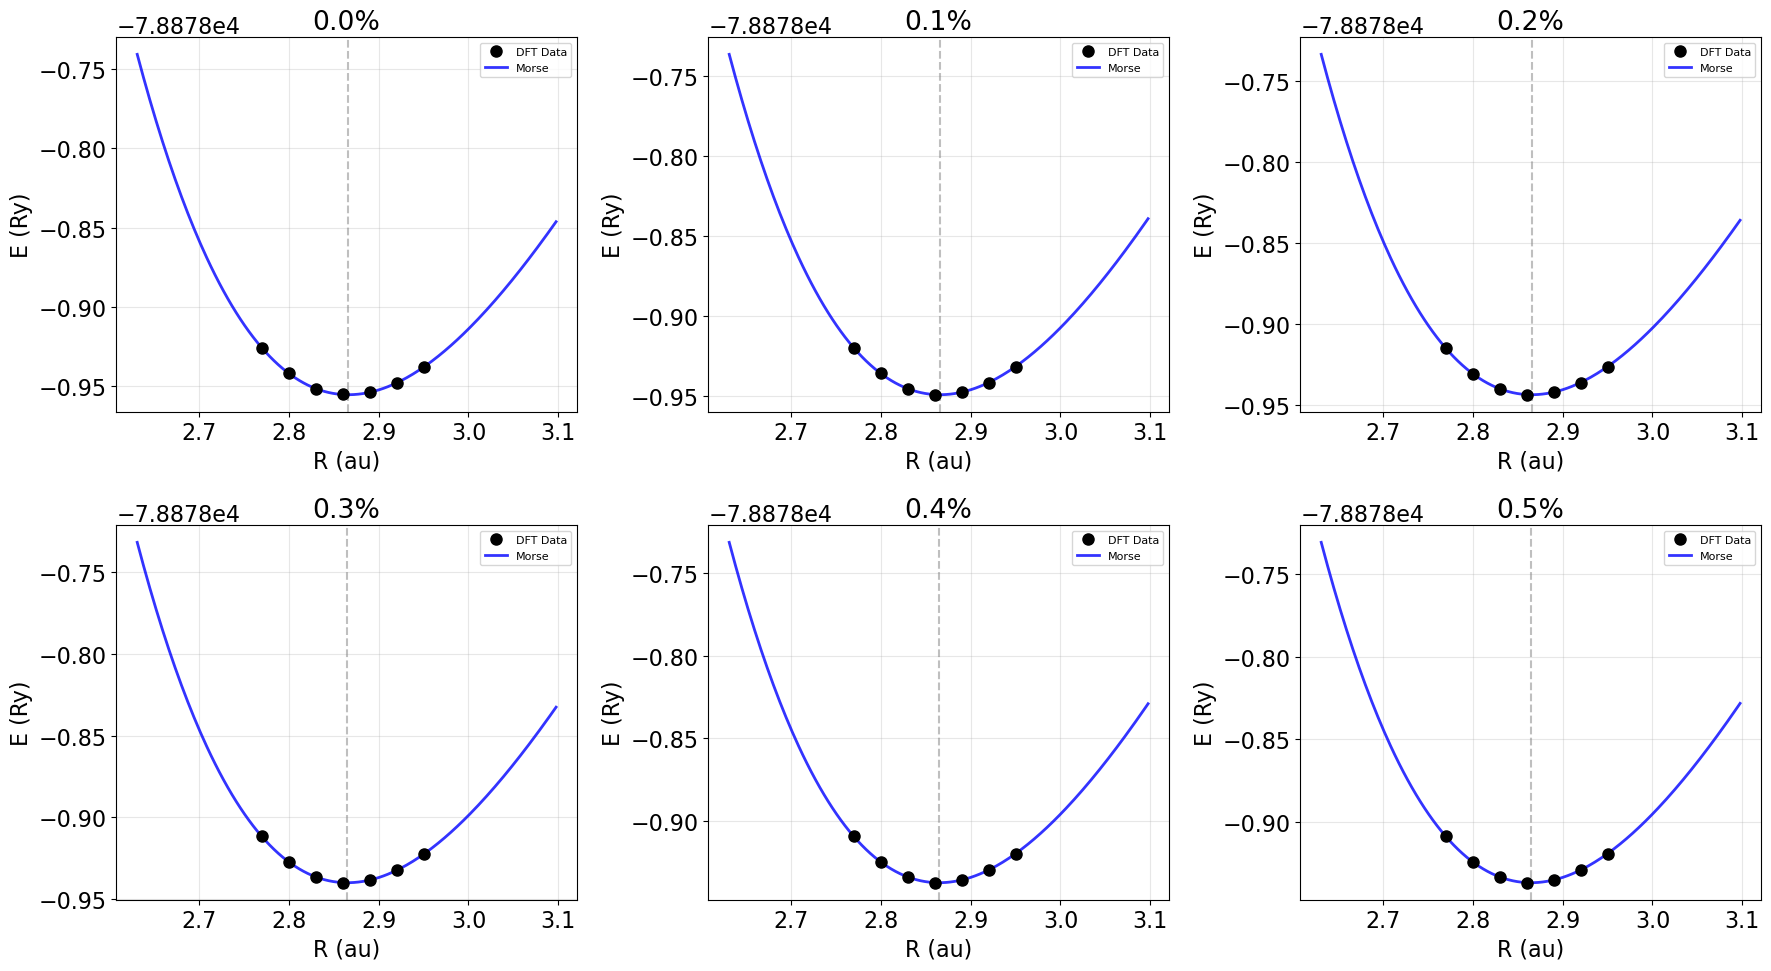

In [14]:
# Calculate subplot layout
n_percs = len(percs)
n_cols = 3  # adjust as needed
n_rows = (n_percs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_percs > 1 else [axes]

for i, p in enumerate(percs):
    # Parse file
    morse = parse_eos_output("perc_"+str(format(p,'.1f'))+"/volume_v2/eos_" + str(format(p,'.1f')) +".out")['morse']

    # Get Morse parameters
    a = morse.additional_params['a']
    b = morse.additional_params['b']
    c = morse.additional_params['c']
    lambda_param = morse.additional_params['lambda']

    # Get data points
    r_data =  [p.r for p in morse.data_points]
    efit_data = [p.efit for p in morse.data_points]

    # Calculate relative energies
    e_relative_data = [morse_energy(r, a, b, c, lambda_param) for r in r_data]
    offset = efit_data[0] - e_relative_data[0]

    # Create smooth curve
    r_min = min(r_data)
    r_max = max(r_data)
    r_smooth = np.linspace(r_min * 0.95, r_max * 1.05, 200)
    e_morse_smooth = np.array([morse_energy(r, a, b, c, lambda_param) + offset for r in r_smooth])

    # Get DFT data
    etot_data = [p.etot for p in morse.data_points]

    # Plot on subplot
    ax = axes[i]
    ax.plot(r_data, etot_data, 'ko', markersize=8, label='DFT Data', zorder=5)
    ax.plot(r_smooth, e_morse_smooth, 'b-', linewidth=2, label='Morse', zorder=3, alpha=0.8)
    ax.axvline(morse.rwseq, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('R (au)')
    ax.set_ylabel('E (Ry)')
    ax.set_title(f'{p:.1f}%')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

# Hide extra subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [15]:

# ratios_sws_opt = {}

# percs = [0.0]

# for p in percs:
#     print(p)

#     ratios = sws_ratios_dict[p]


#     e_lda, e_gga = parse_energies([ratios_ca_opt[p]], ratios, "perc_"+str(format(p,'.1f'))+"/volume", k, id_name="fept")

#     e_gga = [e_gga[i][0] for i in e_gga]


#     results_gga = compute_equation_of_state(
#         np.array(ratios), 
#         np.array(e_gga), 
#         eos_type='polynomial',
#         order=3
#     )

#     # Unpack results
#     v_eq_gga, e_eq_gga, eos_fit_gga, fit_func_gga = results_gga

#     ratios_sws_opt[p] = v_eq_gga

#     # Generate fit curves
#     xfit = np.linspace(min(ratios.min(), ratios.min()) - 0.01, 
#                     max(ratios.max(), ratios.max()) + 0.01, 200)

#     e_fit_gga = fit_func_gga(xfit)

#     # Shift energies to show relative to minimum
#     min_e_gga = min(e_gga)

#     # Plot comparison
#     plt.figure(figsize=(10, 7))


#     # GGA data and fit
#     plt.plot(ratios, np.array(e_gga) - min_e_gga, 's', 
#             color='blue', markersize=8, label='GGA calculated')
#     plt.plot(xfit, e_fit_gga - min_e_gga, '-', 
#             color='blue', linewidth=2, 
#             label=f'GGA fit (c/a = {v_eq_gga:.4f})')

#     # Mark equilibrium positions
#     plt.axvline(v_eq_gga, color='blue', linestyle='--', alpha=0.3)

#     plt.xlabel('c/a ratio', fontsize=12)
#     plt.ylabel('Relative Energy (Ry)', fontsize=12)
#     plt.legend(fontsize=10)
#     plt.title('Equation of State: Polynomial order 3', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig("sws_ratio_p"+ str(format(p,'.1f')) + '.png')



In [16]:

for p in percs:

    ca = all_results_dict[p]['c/a']
    sws = all_results_dict[p]['sws']
    opt_vol = 4*np.pi*((sws*bohr_to_angstrom)**3)*4/3
    a = (opt_vol/ca)**(1/3)
    c = a*ca

    all_results_dict[p]['a'] = a
    all_results_dict[p]['c'] = c
    all_results_dict[p]['vol'] = opt_vol
    all_results_dict[p]['vol_%'] = (opt_vol - fm_results_dict['vol']) / fm_results_dict['vol'] * 100
    all_results_dict[p]['a_%'] = (a - fm_results_dict['a']) / fm_results_dict['a'] * 100
    all_results_dict[p]['c_%'] = (c - fm_results_dict['c']) / fm_results_dict['c'] * 100


    print(f"Fraction: {p}\n")

    print(f"c/a: {ca}, % (FM reference): {all_results_dict[p]['c/a_%']:.4f}%")
    print(f"SWS: {sws}, % (FM reference): {all_results_dict[p]['sws_%']:.4f}%")
    print(f"volume: {opt_vol}, % (FM reference): {all_results_dict[p]['vol_%']:.4f}%")
    print(f"a: {a}, % (FM reference): {all_results_dict[p]['a_%']:.4f}%")
    print(f"c: {c}, % (FM reference): {all_results_dict[p]['c_%']:.4f}%")
    print("\n")





Fraction: 0.0

c/a: 0.9537514755, % (FM reference): 0.0000%
SWS: 2.8664758855, % (FM reference): -0.0009%
volume: 58.47858785261685, % (FM reference): -0.0026%
a: 3.9432461195811688, % (FM reference): -0.0009%
c: 3.760876804810189, % (FM reference): -0.0009%


Fraction: 0.1

c/a: 0.9497764323, % (FM reference): -0.4168%
SWS: 2.8660188994, % (FM reference): -0.0168%
volume: 58.45062357594171, % (FM reference): -0.0504%
a: 3.9481100825498, % (FM reference): 0.1225%
c: 3.7498219085318074, % (FM reference): -0.2948%


Fraction: 0.2

c/a: 0.9466265851, % (FM reference): -0.7470%
SWS: 2.8657670575, % (FM reference): -0.0256%
volume: 58.43521646612859, % (FM reference): -0.0767%
a: 3.95213696181495, % (FM reference): 0.2246%
c: 3.7411979160103748, % (FM reference): -0.5241%


Fraction: 0.3

c/a: 0.944937543, % (FM reference): -0.9241%
SWS: 2.8653510661, % (FM reference): -0.0401%
volume: 58.409772996450414, % (FM reference): -0.1202%
a: 3.953916298862707, % (FM reference): 0.2697%
c: 3.736203

# Optimized structures

In [17]:
for p in percs:

    ca_opt = all_results_dict[p]['c/a'] #np.round(optimal_ca, 2)
    sws_opt = all_results_dict[p]['sws'] #np.round(v_eq_gga, 2)

    # create_emto_inputs(
    #     output_path="perc_"+str(format(p,'.1f'))+"/optimized_v2",
    #     id_name="fept",
    #     job_name=f"dlm_p{p}",
    #     dmax=1.52,
    #     lat=5,
    #     ca_ratios=[ca_opt],
    #     sws_values=[sws_opt],
    #     ks = [k],
    #     magn_type='pm',
    #     perc = p,
    #     from_cif=False,
    #     job_mode='serial',
    #     prcs=8,
    #     time="00:30:00",
    #     NL=3,
    #     NQ3=4,
    #     B=1.0,
    #     fractional_coords=np.array([[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]))

# Parse the results

In [18]:
kgrn_list = []
kfcd_list = []

for p in percs:

    ca_opt = all_results_dict[p]['c/a']
    sws_opt = all_results_dict[p]['sws']

    path="perc_"+str(format(p,'.1f'))+"/optimized_v2/"

    file_kgrn = path + f"fept_{ca_opt:.2f}_{sws_opt:.2f}_k{21}.prn"
    file_kfcd = path + f"fcd/fept_{ca_opt:.2f}_{sws_opt:.2f}_k{21}.prn"

    report, kgrn, kfcd = parse_emto_output(file_kgrn, file_kfcd)

    kgrn_list.append(kgrn)
    kfcd_list.append(kfcd)

    save_report(report, path + 'opt_summary.txt')




Report saved to: perc_0.0/optimized_v2/opt_summary.txt
Report saved to: perc_0.1/optimized_v2/opt_summary.txt
Report saved to: perc_0.2/optimized_v2/opt_summary.txt
Report saved to: perc_0.3/optimized_v2/opt_summary.txt
Report saved to: perc_0.4/optimized_v2/opt_summary.txt
Report saved to: perc_0.5/optimized_v2/opt_summary.txt


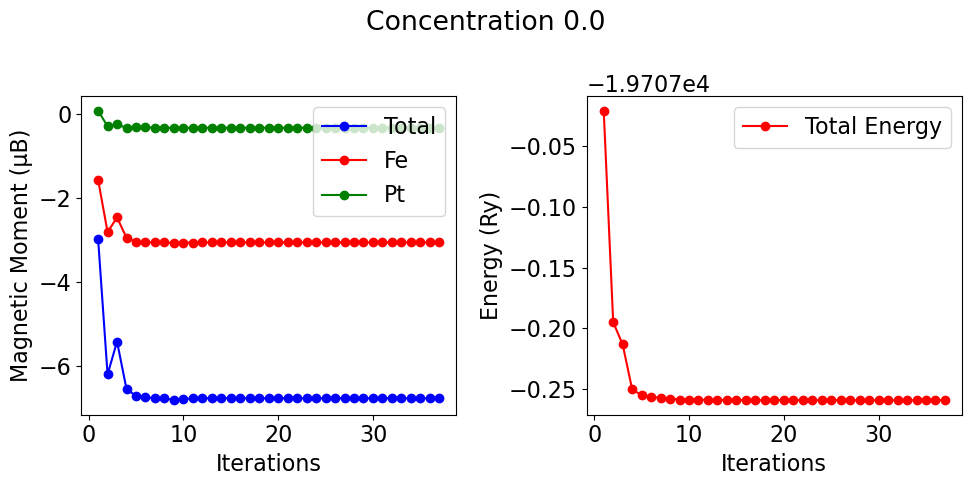

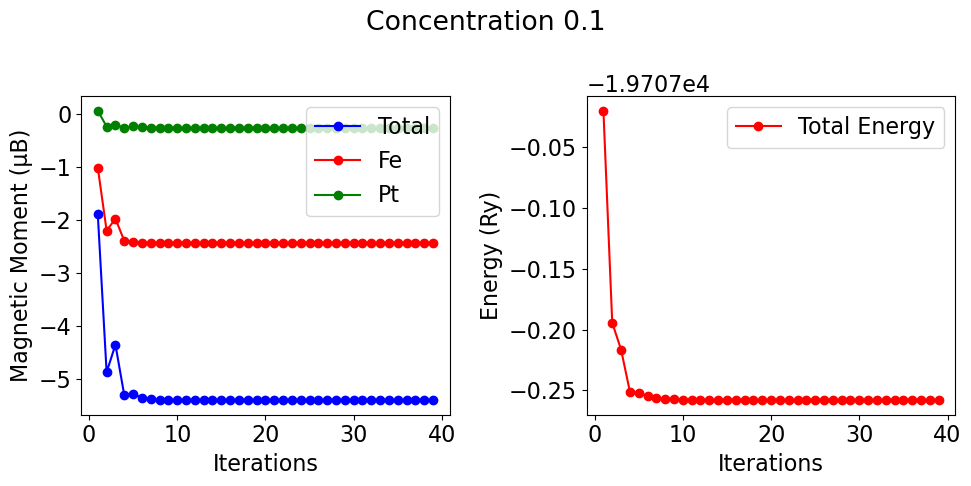

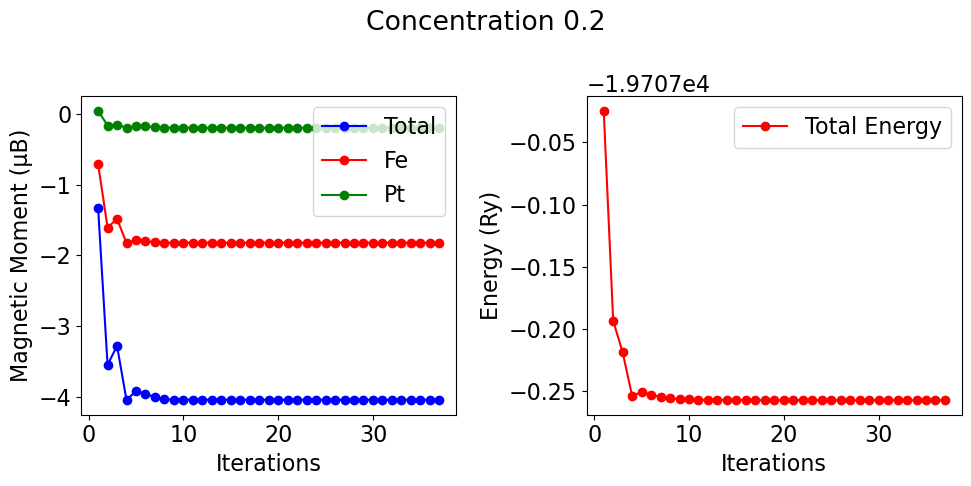

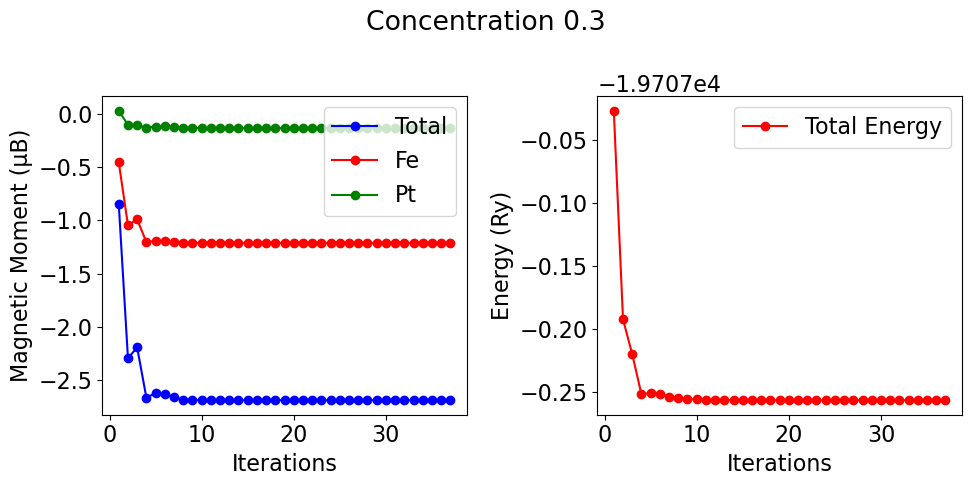

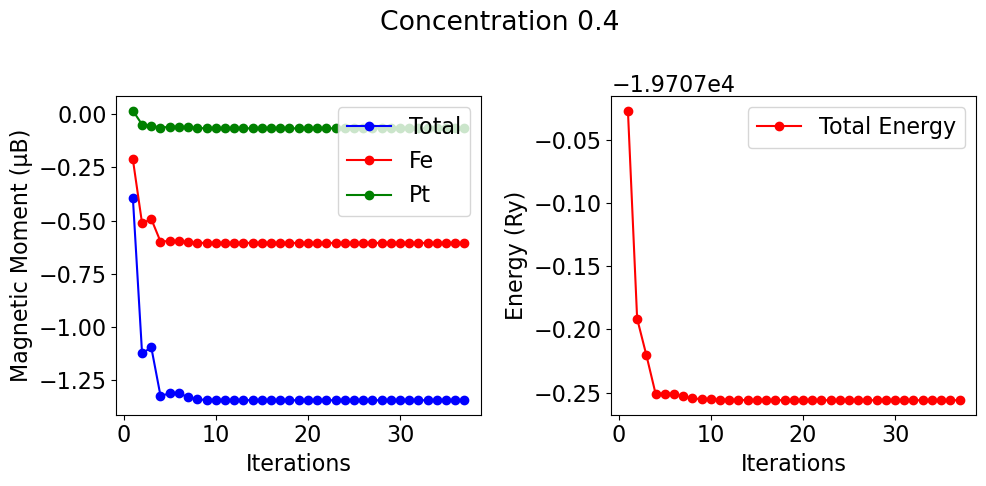

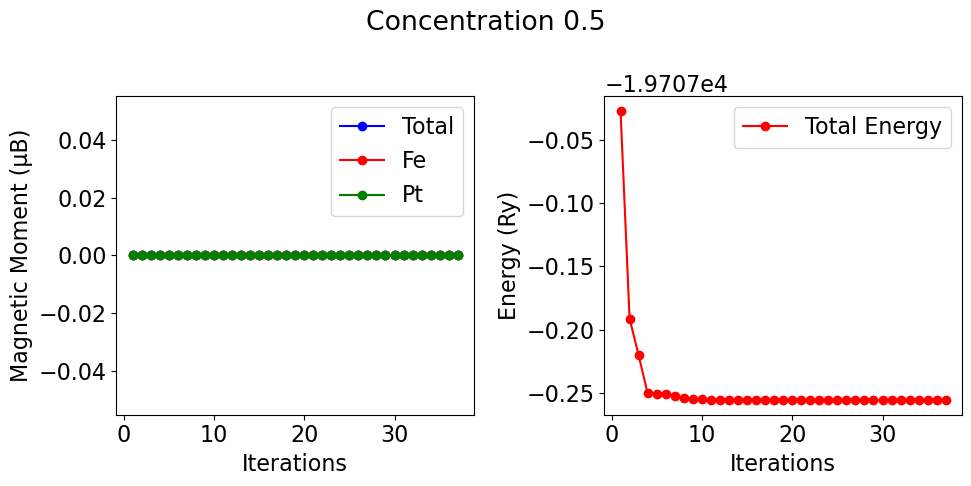

In [19]:
for index in range(len(kgrn_list)):
    kgrn = kgrn_list[index]
    kfcd = kfcd_list[index]

    tot_mag = []
    fe_mag = []
    pt_mag = []
    tot_ene = []
    fermi_ene = []

    for i in kgrn.iterations:
        tot_mag.append(i.total_magnetic_moment)
        fe_mag.append(i.weighted_magnetic_moments.get(2))
        pt_mag.append(i.weighted_magnetic_moments.get(1))
        tot_ene.append(i.energy)
        
    iterations = range(1, len(tot_mag) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- Subplot 1: Magnetic Moments (Total + Elements) ---
    axes[0].plot(iterations, tot_mag, 'o-', label='Total', color='blue')
    axes[0].plot(iterations, fe_mag, 'o-', label='Fe', color='red')
    axes[0].plot(iterations, pt_mag, 'o-', label='Pt', color='green')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Magnetic Moment (μB)')
    axes[0].legend(loc='upper right')

    # --- Subplot 2: Element-specific Magnetic Moments ---
    axes[1].plot(iterations, tot_ene, 'o-', color='red', label='Total Energy')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Energy (Ry)')
    axes[1].legend()
    fig.suptitle(f'Concentration {percs[index]}')
    plt.tight_layout()
    plt.savefig("convergence_p"+ str(format(percs[index],'.1f')) + '.png')
    plt.show()



# DOS

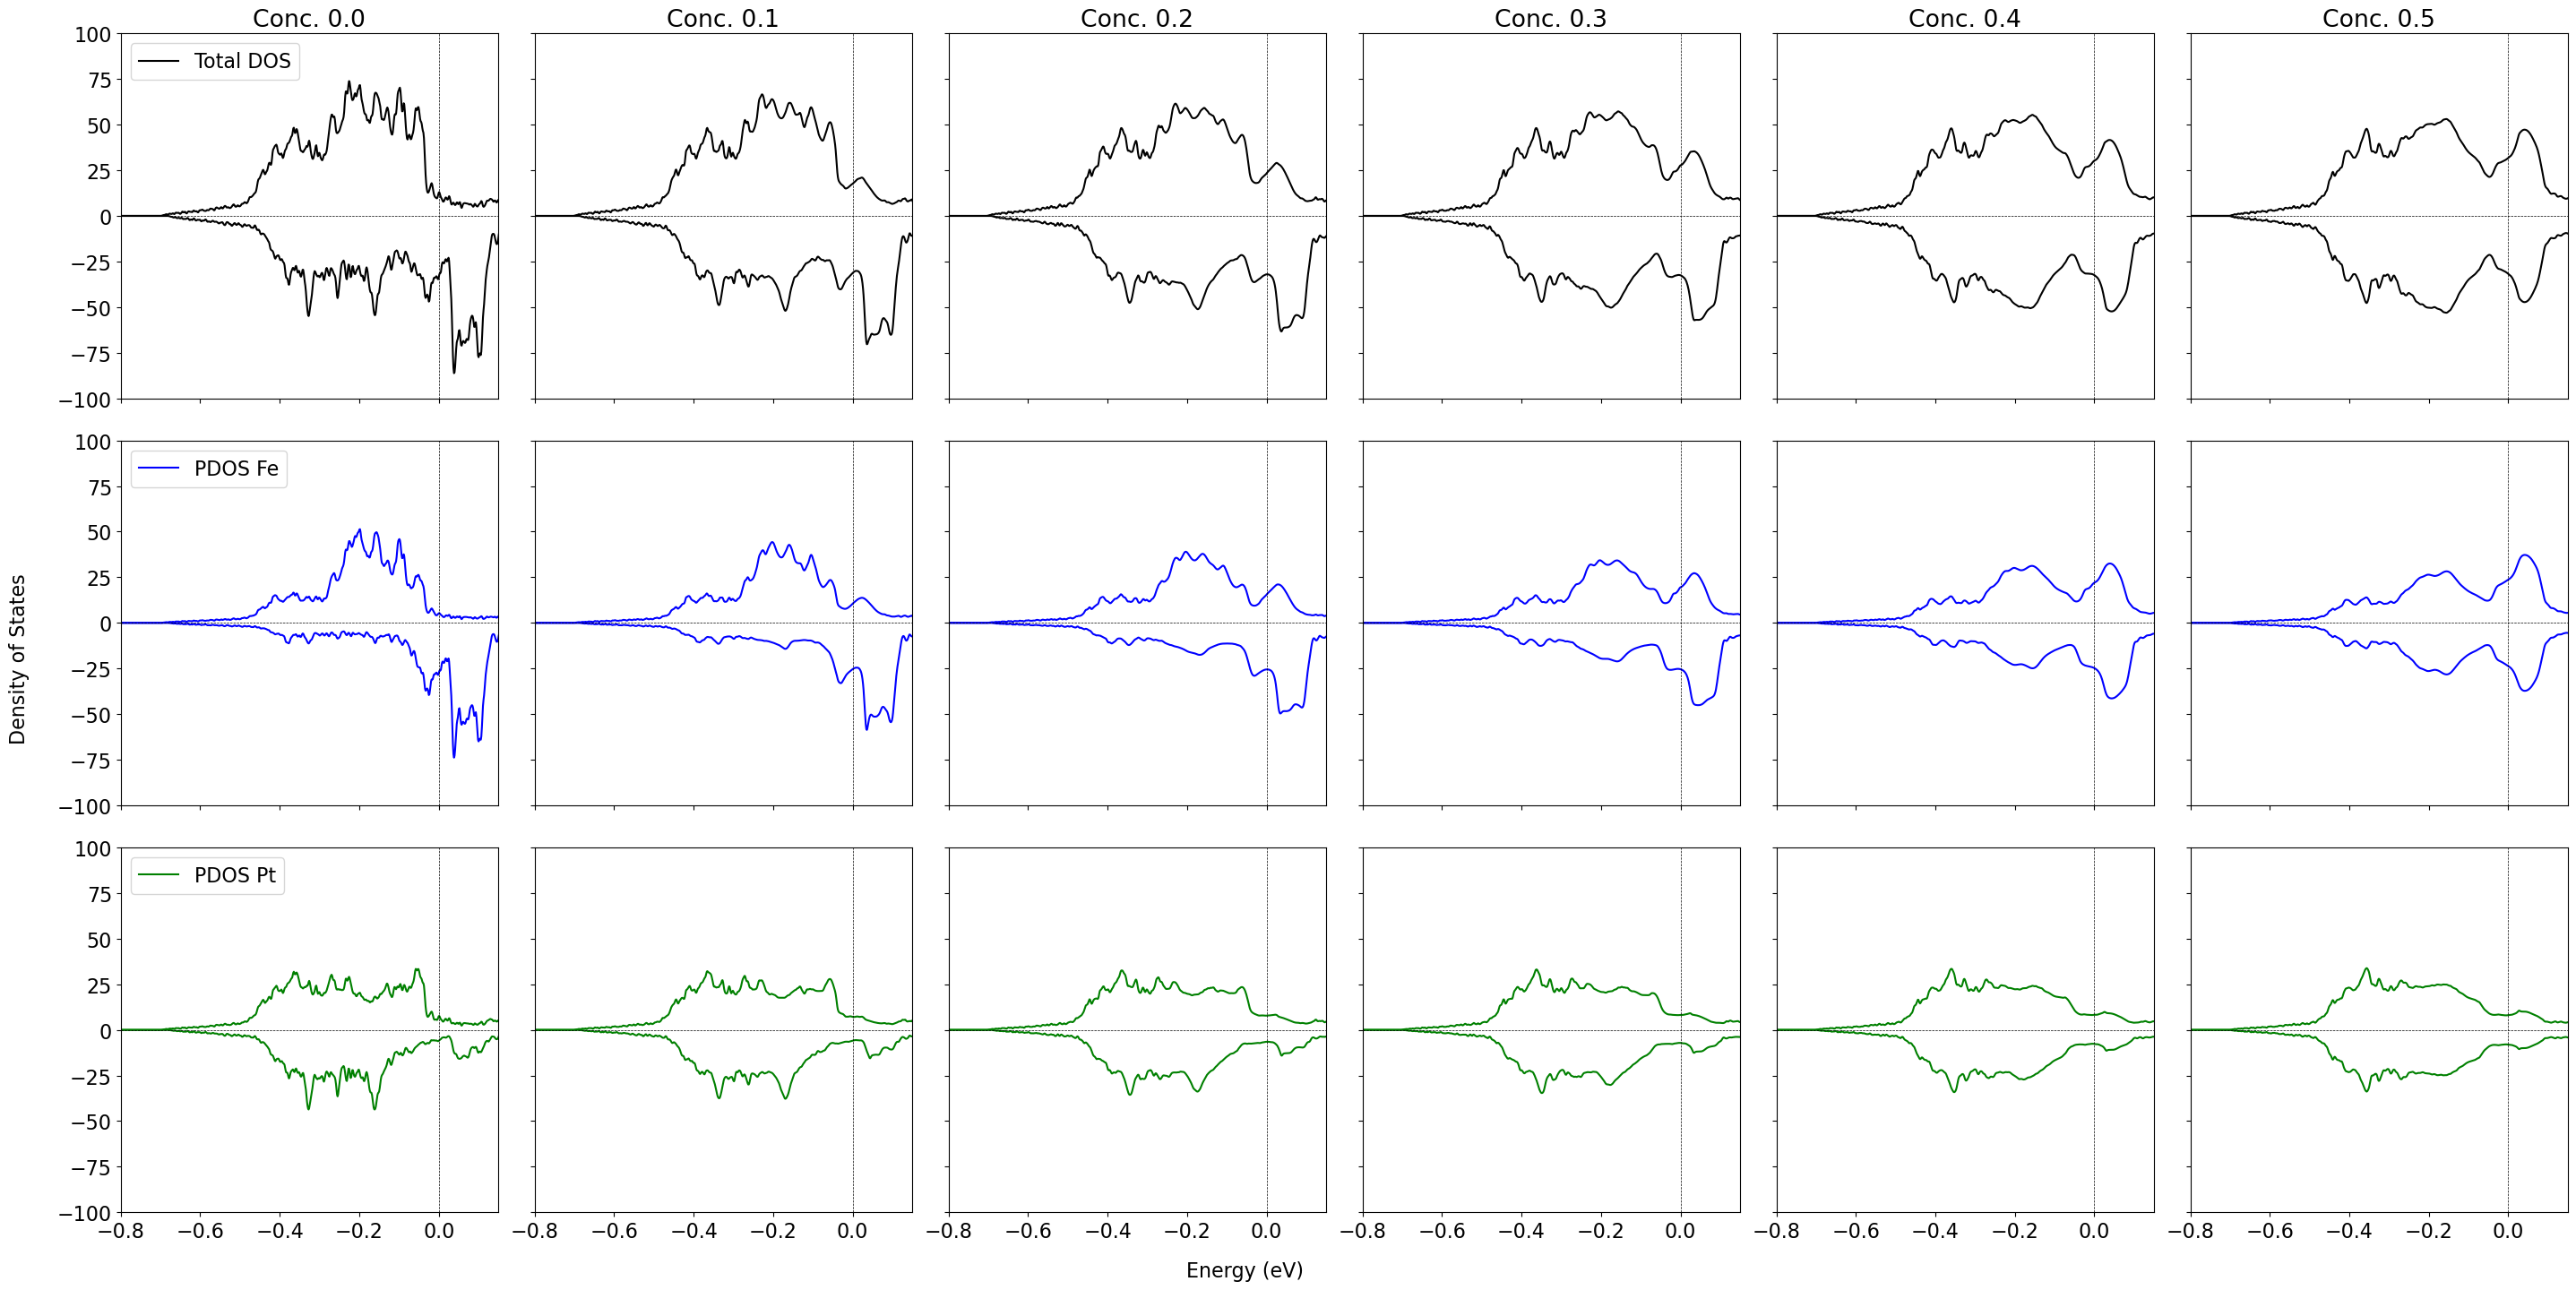

In [22]:
n_cols = len(kgrn_list)
fig, axes = plt.subplots(3, n_cols, figsize=(5*n_cols, 15), sharex=True, sharey=True)

if n_cols == 1:
    axes = axes.reshape(-1, 1)

for index in range(len(kgrn_list)):
    kfcd = kfcd_list[index]
    p = percs[index]
    ca_opt = all_results_dict[p]['c/a']
    sws_opt = all_results_dict[p]['sws']
    k = 21

    dos_file = f'perc_{p:.1f}/optimized_v2/fept_{ca_opt:.2f}_{sws_opt:.2f}_k{k}.dos'

    parser = DOSParser(dos_file)
    dos_down, dos_up = parser.get_dos(data_type='total')
    fe_down, fe_up = parser.get_dos(data_type='sublattice', sublattice=2)
    pt_down, pt_up = parser.get_dos(data_type='sublattice', sublattice=1)

    # Total DOS
    axes[0, index].plot(dos_down[:, 0], dos_down[:, 1], 'k')
    axes[0, index].plot(dos_up[:, 0], -1 * dos_up[:, 1], 'k', label='Total DOS')
    axes[0, index].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[0, index].axvline(0, color='black', linewidth=0.5, linestyle='--')
    axes[0, index].set_xlim([-0.8, 0.15])
    axes[0, index].set_ylim([-100, 100])
    if index == 0:
        axes[0, index].legend()
    axes[0, index].set_title(f'Conc. {p}')

    # PDOS Fe
    axes[1, index].plot(fe_down[:, 0], 2*fe_down[:, 1], 'b')
    axes[1, index].plot(fe_up[:, 0], -2 * fe_up[:, 1], 'b', label='PDOS Fe')
    axes[1, index].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[1, index].axvline(0, color='black', linewidth=0.5, linestyle='--')
    axes[1, index].set_xlim([-0.8, 0.15])
    if index == 0:
        axes[1, index].legend()

    # PDOS Pt
    axes[2, index].plot(pt_down[:, 0], 2*pt_down[:, 1], 'g')
    axes[2, index].plot(pt_up[:, 0], -2 * pt_up[:, 1], 'g', label='PDOS Pt')
    axes[2, index].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axes[2, index].axvline(0, color='black', linewidth=0.5, linestyle='--')
    axes[2, index].set_xlim([-0.8, 0.15])
    if index == 0:
        axes[2, index].legend()

fig.text(0.5, 0.04, 'Energy (eV)', ha='center')
fig.text(0.04, 0.5, 'Density of States', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig("dos_all.png")
plt.show()

In [23]:
fe_mom = []
pt_mom = []
tot_mom = []

sws = [all_results_dict[p]['sws'] for p in percs]
vol = [all_results_dict[p]['vol'] for p in percs]
a = [all_results_dict[p]['a'] for p in percs]
c = [all_results_dict[p]['c'] for p in percs]
ca = [all_results_dict[p]['c/a'] for p in percs]

sws_p = [all_results_dict[p]['sws_%'] for p in percs]
vol_p = [all_results_dict[p]['vol_%'] for p in percs]
a_p = [all_results_dict[p]['a_%'] for p in percs]
c_p = [all_results_dict[p]['c_%'] for p in percs]
ca_p = [all_results_dict[p]['c/a_%'] for p in percs]


for index in range(len(percs)):
    p = percs[index]
    kfcd = kfcd_list[index]
    
    pt_mom.append(kfcd.weighted_magnetic_moments[1])
    fe_mom.append(kfcd.weighted_magnetic_moments[3])
    tot_mom.append(kfcd.total_magnetic_moment)



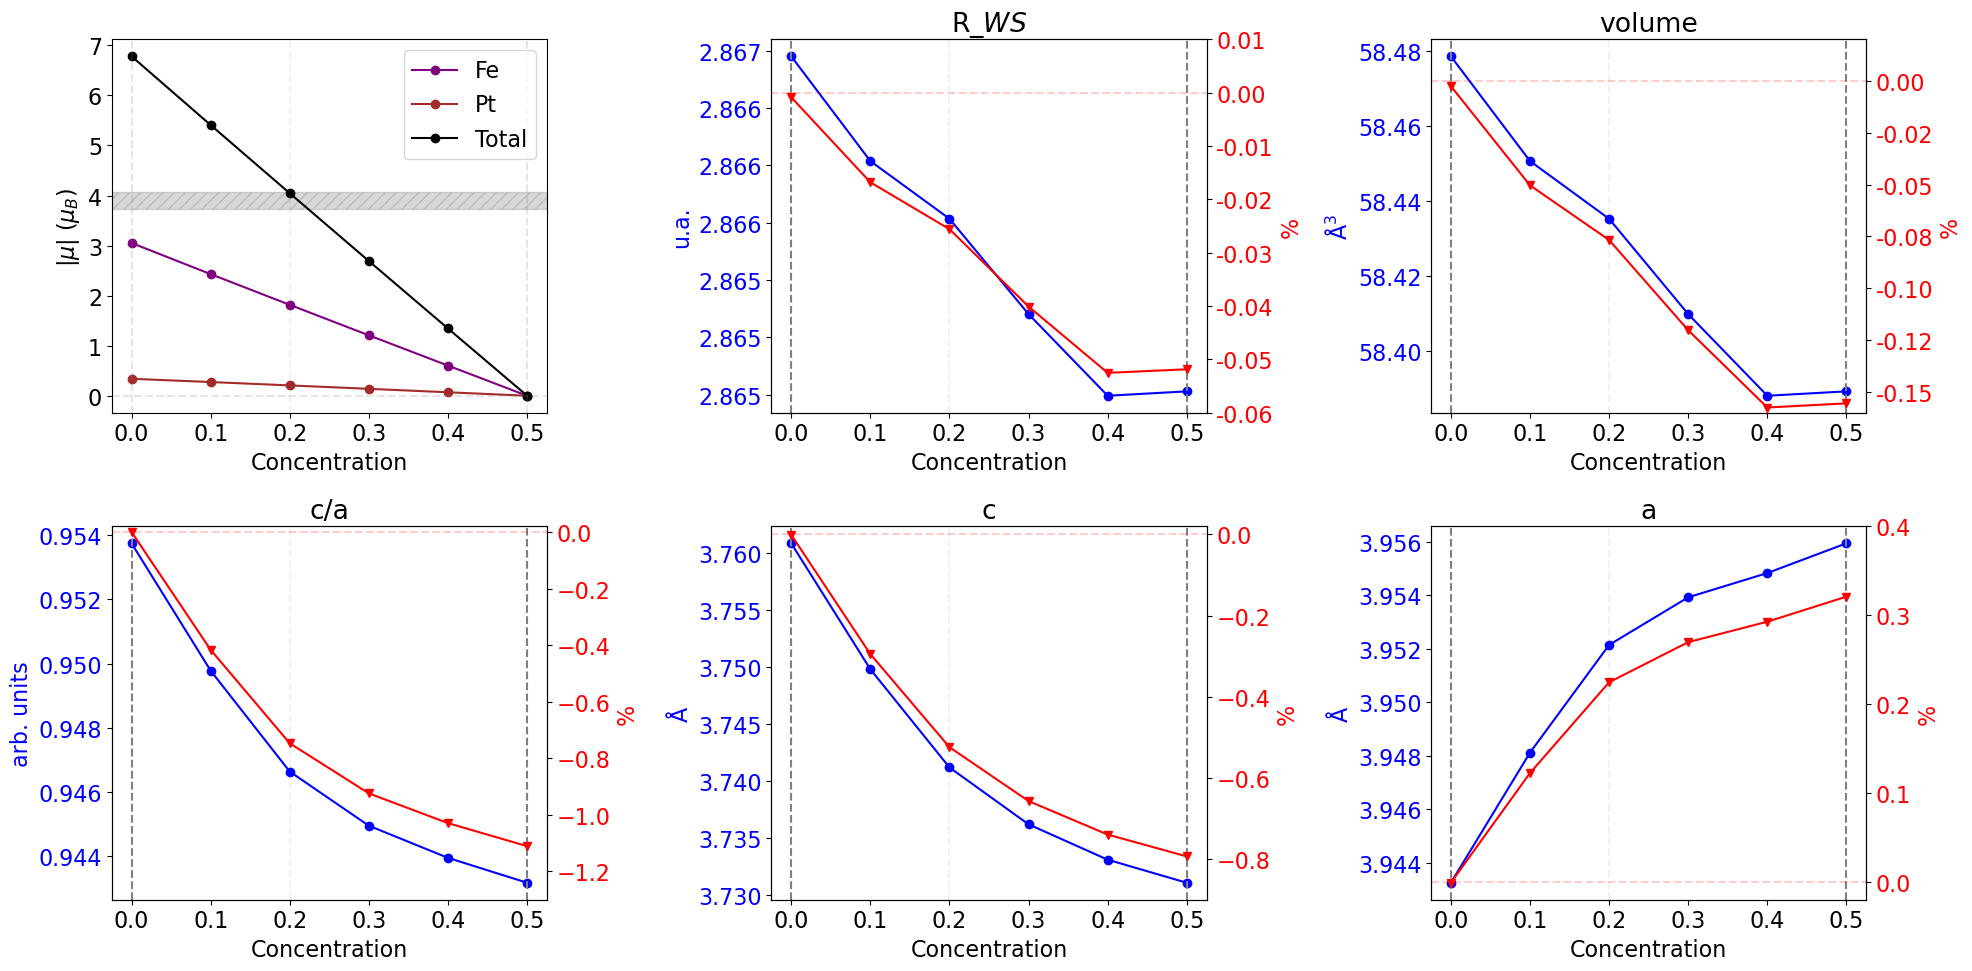

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Remove sharey=True

ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]


ax1.plot(percs, np.abs(fe_mom), marker='o', color='purple', label='Fe')
ax1.plot(percs, np.abs(pt_mom), marker='o', color='brown', label='Pt')
ax1.plot(percs, np.abs(tot_mom), marker='o', color='black', label='Total')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.2)
ax1.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
max_tot_mom = np.max(np.abs(tot_mom))
ax1.axhspan(0.55*max_tot_mom, 0.6*max_tot_mom, alpha=0.3, color='gray', hatch='///')
ax1.set_ylabel('|$\mu$| ($\mu_B$)')
ax1.set_xlabel('Concentration')

ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.2)
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.2)
ax1.legend()  # Move legend to axes[0]


### SWS ####

ax2.plot(percs, sws, marker='o', color='blue')
ax2.axvline(x=0, color='gray', linestyle='--')
ax2.axvline(x=0.5, color='gray', linestyle='--')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
ax2.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
ax2.set_xlabel('Concentration')
ax2.set_ylabel('u.a.', color='blue')
ax2.set_title('R_$WS$')

ax = ax2.twinx()
ax.plot(percs, sws_p, 'r-v')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.2)
ax.tick_params(axis='y', labelcolor='red')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.set_ylim([-0.06,0.01])
ax.set_ylabel('%', color='red')



### VOLUME ####

ax3.plot(percs, vol, marker='o', color='blue')
ax3.axvline(x=0, color='gray', linestyle='--')
ax3.axvline(x=0.5, color='gray', linestyle='--')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax3.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
ax3.set_xlabel('Concentration')
ax3.set_ylabel('Å$^3$', color='blue')
ax3.set_title('volume')

ax = ax3.twinx()
ax.plot(percs, vol_p, 'r-v')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.2)
ax.tick_params(axis='y', labelcolor='red')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.set_ylim([-0.16,0.02])
ax.set_ylabel('%', color='red')

### C/A ####

ax4.plot(percs, ca, marker='o', color='blue')
ax4.axvline(x=0, color='gray', linestyle='--')
ax4.axvline(x=0.5, color='gray', linestyle='--')
ax4.tick_params(axis='y', labelcolor='blue')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
ax4.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
ax4.set_xlabel('Concentration')
ax4.set_ylabel('arb. units', color='blue')
ax4.set_title('c/a')

ax = ax4.twinx()
ax.plot(percs, ca_p, 'r-v')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.2)
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylim([-1.3,0.02])
ax.set_ylabel('%', color='red')

### C ####

ax5.plot(percs, c, marker='o', color='blue')
ax5.axvline(x=0, color='gray', linestyle='--')
ax5.axvline(x=0.5, color='gray', linestyle='--')
ax5.tick_params(axis='y', labelcolor='blue')
ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
ax5.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
ax5.set_xlabel('Concentration')
ax5.set_ylabel('Å', color='blue')
ax5.set_title('c')

ax = ax5.twinx()
ax.plot(percs, c_p, 'r-v')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.2)
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylim([-0.9,0.02])
ax.set_ylabel('%', color='red')

### A ####

ax6.plot(percs, a, marker='o', color='blue')
ax6.axvline(x=0, color='gray', linestyle='--')
ax6.axvline(x=0.5, color='gray', linestyle='--')
ax6.tick_params(axis='y', labelcolor='blue')
ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
ax6.axvline(x=0.2, color='gray', linestyle='--', alpha=0.1)
ax6.set_xlabel('Concentration')
ax6.set_ylabel('Å', color='blue')
ax6.set_title('a')

ax = ax6.twinx()
ax.plot(percs, a_p, 'r-v')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.2)
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylim([-0.02,0.4])
ax.set_ylabel('%', color='red')





plt.tight_layout()
plt.show()

In [25]:
pd.DataFrame(all_results_dict).to_csv("pm_percentages_results.csv")


# Testing different EOS

In [26]:
diff_parameters = {'MO88': 0, 'SPLN': 0, 'POLN': 0}


for j in diff_parameters: 

    diff_parameters[j] = {}


    for p in percs:

        diff_parameters[j][p] = {}

        ## C/A RATIO OPTIMIZATION ##

        e_lda, e_gga = parse_energies(ratios, initial_sws, "perc_"+str(format(p,'.1f'))+"/ratio_ca", k, id_name="fept")

        create_eos_input(f"perc_{str(format(p,'.1f'))}/ratio_ca/eos_{j}.dat", f"eos_p{str(format(p,'.1f'))}_{j}", f"ratio c/a p{str(format(p,'.1f'))}",  ratios, e_gga, fit_type=j)


        # Run command in specific directory, automatically returns to original
        result = subprocess.run(f"/home/x_pamca/postdoc_proj/emto/bin/eos.exe < eos_{j}.dat", 
                            shell=True, 
                            cwd="perc_"+str(format(p,'.1f'))+"/ratio_ca",
                            capture_output=True, 
                            text=True)


        results = parse_eos_output("perc_"+str(format(p,'.1f'))+"/ratio_ca/" + f"eos_p{str(format(p,'.1f'))}_{j}" +".out")
        value = list(results.values())[0]

        diff_parameters[j][p]['c/a'] = value.rwseq
        diff_parameters[j][p]['c/a_%'] = (value.rwseq - fm_results_dict['c/a']) / fm_results_dict['c/a'] * 100


        # SWS OPTIMIZATION ##

        e_lda, e_gga = parse_energies([diff_parameters['MO88'][p]['c/a']], sws_ratios, "perc_"+str(format(p,'.1f'))+"/volume_v2", k, id_name="fept")
        e_gga = [e_gga[i][0] for i in e_gga]

        create_eos_input(f"perc_{str(format(p,'.1f'))}/volume_v2/eos_{j}.dat", f"eos_p{str(format(p,'.1f'))}_{j}", f"volume sws p{str(format(p,'.1f'))}",  sws_ratios, e_gga, fit_type=j)


        # Run command in specific directory, automatically returns to original
        result = subprocess.run(f"/home/x_pamca/postdoc_proj/emto/bin/eos.exe < eos_{j}.dat", 
                            shell=True, 
                            cwd="perc_"+str(format(p,'.1f'))+"/volume_v2",
                            capture_output=True, 
                            text=True)


        results = parse_eos_output("perc_"+str(format(p,'.1f'))+"/volume_v2/" + f"eos_p{str(format(p,'.1f'))}_{j}" +".out")
        value = list(results.values())[0]

        diff_parameters[j][p]['sws'] = value.rwseq
        diff_parameters[j][p]['sws_%'] = (value.rwseq - fm_results_dict['sws']) / fm_results_dict['sws'] * 100

        ca = diff_parameters['MO88'][p]['c/a']
        sws = diff_parameters[j][p]['sws']
        opt_vol = 4*np.pi*((sws*bohr_to_angstrom)**3)*4/3
        a = (opt_vol/ca)**(1/3)
        c = a*ca
            
        diff_parameters[j][p]['a'] = a
        diff_parameters[j][p]['c'] = c
        diff_parameters[j][p]['vol'] = opt_vol
        diff_parameters[j][p]['vol_%'] = (opt_vol - fm_results_dict['vol']) / fm_results_dict['vol'] * 100
        diff_parameters[j][p]['a_%'] = (a - fm_results_dict['a']) / fm_results_dict['a'] * 100
        diff_parameters[j][p]['c_%'] = (c - fm_results_dict['c']) / fm_results_dict['c'] * 100
  

EOS input file 'perc_0.0/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.0/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.1/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.1/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.2/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.2/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.3/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.3/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.4/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.4/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.5/ratio_ca/eos_MO88.dat' created successfully.
EOS input file 'perc_0.5/volume_v2/eos_MO88.dat' created successfully.
EOS input file 'perc_0.0/ratio_ca/eos_SPLN.dat' created successfully.
EOS input file 'perc_0.0/volume_v2/eos_SPLN.dat' created successfully.
EOS input fil

In [27]:

sws_p_MO88 = [diff_parameters['MO88'][p]['sws_%'] for p in percs]
vol_p_MO88 = [diff_parameters['MO88'][p]['vol_%'] for p in percs]
ca_p_MO88 = [diff_parameters['MO88'][p]['c/a_%'] for p in percs]

sws_p_POLN = [diff_parameters['POLN'][p]['sws_%'] for p in percs]
vol_p_POLN = [diff_parameters['POLN'][p]['vol_%'] for p in percs]
ca_p_POLN = [diff_parameters['POLN'][p]['c/a_%'] for p in percs]

sws_p_SPLN = [diff_parameters['SPLN'][p]['sws_%'] for p in percs]
vol_p_SPLN = [diff_parameters['SPLN'][p]['vol_%'] for p in percs]
ca_p_SPLN = [diff_parameters['SPLN'][p]['c/a_%'] for p in percs]

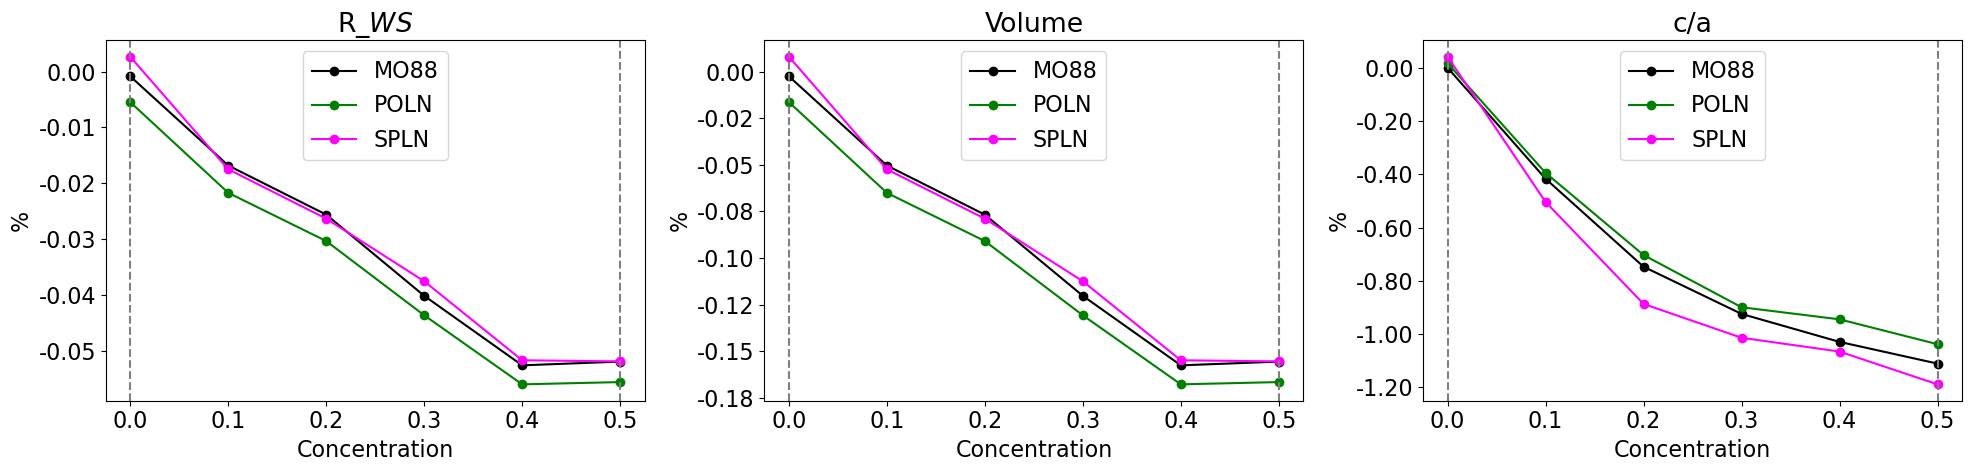

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # Remove sharey=True

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


### SWS ####

ax1.plot(percs, sws_p_MO88, marker='o', color='black', label='MO88')
ax1.plot(percs, sws_p_POLN, marker='o', color='green', label='POLN')
ax1.plot(percs, sws_p_SPLN, marker='o', color='magenta', label='SPLN')
ax1.legend()
ax1.axvline(x=0, color='gray', linestyle='--')
ax1.axvline(x=0.5, color='gray', linestyle='--')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax1.set_xlabel('Concentration')
ax1.set_ylabel('%')
ax1.set_title('R_$WS$')




### VOLUME ####

ax2.plot(percs, vol_p_MO88, marker='o', color='black', label='MO88')
ax2.plot(percs, vol_p_POLN, marker='o', color='green', label='POLN')
ax2.plot(percs, vol_p_SPLN, marker='o', color='magenta', label='SPLN')
ax2.legend()
ax2.axvline(x=0, color='gray', linestyle='--')
ax2.axvline(x=0.5, color='gray', linestyle='--')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax2.set_xlabel('Concentration')
ax2.set_ylabel('%')
ax2.set_title('Volume')


### C/A ####

ax3.plot(percs, ca_p_MO88, marker='o', color='black', label='MO88')
ax3.plot(percs, ca_p_POLN, marker='o', color='green', label='POLN')
ax3.plot(percs, ca_p_SPLN, marker='o', color='magenta', label='SPLN')
ax3.legend()
ax3.axvline(x=0, color='gray', linestyle='--')
ax3.axvline(x=0.5, color='gray', linestyle='--')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax3.set_xlabel('Concentration')
ax3.set_ylabel('%')
ax3.set_title('c/a')





plt.tight_layout()
plt.show()